# Dashboard: Student Status Engine                            

Owner: Rakesh Katuwal

This is a demo dashboard for Student Status Engine. We will be displaying the total user annotations, predictions in the system and accuracy.



## Data Sources

+ label_predictions.json: Pramesh passed this file to me in 12 August, 2020

## Changes

+ 12-08-2020: Started project

## Things to do:

+ Need to check the date (week) grouping carefully.
+ Write a script to automatically run this script every Friday?
+ Write a script to extract the required info from Snowflake (think about scalabilty: just fetch weekly info and update the dashboard)

## Dataset Description and other notes

+ courseId: course Id 
+ predictedUser: users Id
+ originalLabel: prediction without any processing
+ originalConfidence: the confidence score for the original label
+ revisedLabel: predicted label after some processing (weight decay) --> need to use this for further processing
+ revisedConfidence: the confidence score for the revised label, 0 for annotations by instructors
+ predictedDate:
+ predictBy: predicted by machine (MACH) or instructor (INS)
+ createdDate: ask the team to fill these
+ modifiedDate: 
+ createdUser:
+ lastModifiedUser

Note:
+ Cold start: Green labels for all users at the beginning
+ Revised label: Uses weight decay (ask the team to write exact details)
+ Flag for colleges not implemented. Colleges can be identified by courseId? Need to confirm.

In [1]:
#for large datasets, use dask.dataframe
import pandas as pd 
import numpy as np
import json
from pandas.io.json import json_normalize
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
raw_file = Path.cwd() / "label_predictions.json"

with open(raw_file) as f:
    data = json.load(f)

# converting json dataset from dictionary to dataframe
original_df = pd.DataFrame.from_dict(data)
#df = pd.DataFrame.from_dict(json_normalize(data))
original_df.head()

,_id,revisedLabel,predictedUser,revisedConfidence,originalConfidence,originalLabel,courseId,predictedDate,predictBy,createdDate,modifiedDate,createdUser,lastModifiedUser
0,{'$oid': '5edef29a97c7f5004251e05e'},Green,5ec7dfa38d69d00042dabcbd,0.821,0.821,Green,5ec50642ab6f9b0043a1c19c,{'$date': 1591660800000},MACH,{'$date': 1591669402612},{'$date': 1591669402612},NaN,NaN
1,{'$oid': '5edef29a97c7f5004251e05f'},Green,5ec7dfa38d69d00042dabcbd,0.821,0.821,Green,5ec50642ab6f9b0043a1c1ac,{'$date': 1591660800000},MACH,{'$date': 1591669402612},{'$date': 1591669402612},NaN,NaN
2,{'$oid': '5edef29a97c7f5004251e060'},Green,5ec7dfa38d69d00042dabcbd,0.791,0.791,Green,5ec50642ab6f9b0043a1c1b0,{'$date': 1591660800000},MACH,{'$date': 1591669402613},{'$date': 1591669402613},NaN,NaN
3,{'$oid': '5edef29a97c7f5004251e061'},Green,5ec7dfa38d69d00042dabcbd,0.791,0.791,Green,5ec50642ab6f9b0043a1c1b4,{'$date': 1591660800000},MACH,{'$date': 1591669402614},{'$date': 1591669402614},NaN,NaN
4,{'$oid': '5edef29a97c7f5004251e062'},Green,5ec7db4a8d69d00042dabbc0,0.791,0.791,Green,5ec50642ab6f9b0043a1c196,{'$date': 1591660800000},MACH,{'$date': 1591669402615},{'$date': 1591669402615},NaN,NaN


In [3]:
original_df.columns

Index(['_id', 'revisedLabel', 'predictedUser', 'revisedConfidence',
       'originalConfidence', 'originalLabel', 'courseId', 'predictedDate',
       'predictBy', 'createdDate', 'modifiedDate', 'createdUser',
       'lastModifiedUser'],
      dtype='object')

In [4]:
pd.set_option('mode.chained_assignment', None)

# Creating new dataframe with just the columns needed
df = original_df[['predictedUser','courseId','revisedLabel','revisedConfidence','predictBy','createdDate','predictedDate','modifiedDate']]

# Prediction dates for instructors are NaN. Filtering predictions by MACH.
df_MACH = df[df['predictedDate'].notna()]

# Extracting date values from dictionary
df_MACH['predictedDate'] = [dates.get('$date') for dates in df_MACH.predictedDate]

# Convert epoch time to human-readable date and time 
#df_MACH['predictedDate'] = df_MACH.predictedDate.map(lambda x: datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d"))
df_MACH['predictedDate'] = pd.to_datetime(df_MACH['predictedDate'],unit='ms')
#df_MACH.head()

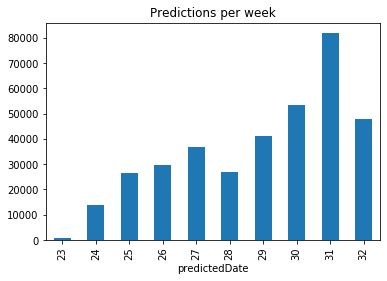

In [5]:
# Bin the dates by weeks and compute the weekly predcitions made by the machine
# The first week starts from 07-06-2020

predictions_MACH_week = df_MACH.predictedDate.groupby(df_MACH.predictedDate.dt.week).count()
predictions_MACH_week.plot(kind='bar',title='Predictions per week')
# df_MACH[df_MACH.predictedDate==pd.Timestamp(2020,6,9)].count()
# value_to_check = pd.Timestamp(2020, 6, 10)
# filter_mask = df_MACH['predictedDate'] < value_to_check
# filtered_df = df_MACH[filter_mask]
# filtered_df.count()